# Examples
In this Notebook, we provide a few examples comparing the several optimization methods.\
We organize the Notebook as follows:
* First, we visualize the type of data and the graphs we consider:
    * Display examples of local data for the binary classification task.
    * Display examples of local data for the Linear Regression task.
    * Display of the several fixed topology graphs we studied.
    * Display of the random geometric graphs used for the time-varying setting, with 2 different values of parameter $\chi$.
* Then, we compare the 4 optimizers we support ([MSDA](https://arxiv.org/pdf/1702.08704.pdf), [ADOM+](https://openreview.net/attachment?id=L8-54wkift&name=supplementary_material), [Continuized](https://arxiv.org/pdf/2106.07644.pdf), [DADAO](https://hal.archives-ouvertes.fr/hal-03737694/document)).

## Visualization of the type of data and graphs considered

In [24]:
import data
import importlib
importlib.reload(data)
from data import create_sample_data
from visualization import plot_3_classif, plot_3_reg, plot_all_fixed_graphs, plot_2_time_varying_graph_sequence

In [25]:
# Variables for the problem
n_workers=50
n_samples= n_workers*100

### Data 1: Binary Classification

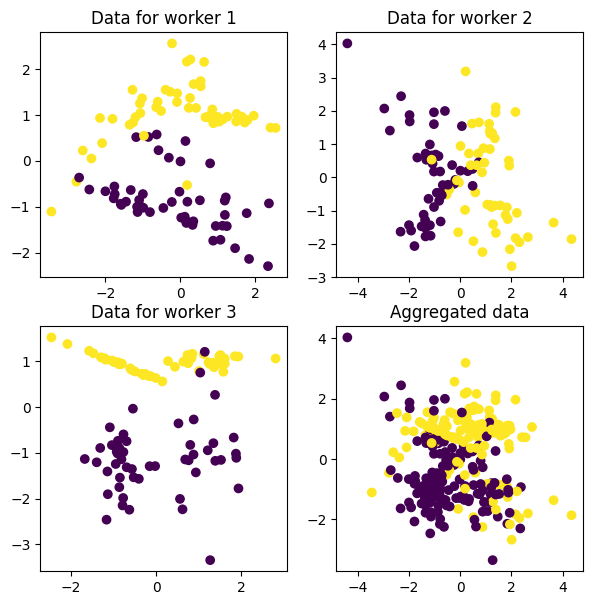

In [26]:
dim=2
classification = True
data, labels = create_sample_data(n_samples, dim, n_workers, classification)
plot_3_classif(data, labels)

### Data 2: Linear Regression

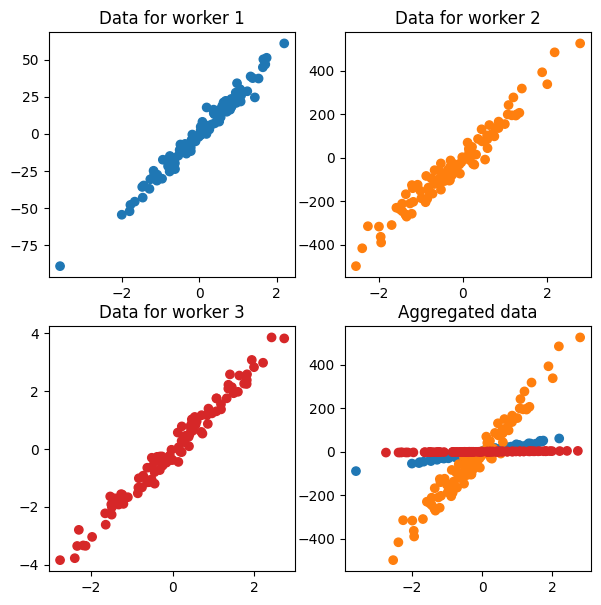

In [29]:
dim=1
classification = False
data, labels = create_sample_data(n_samples, dim, n_workers, classification)
plot_3_reg(data, labels)

### Graphs 1: Fixed topology

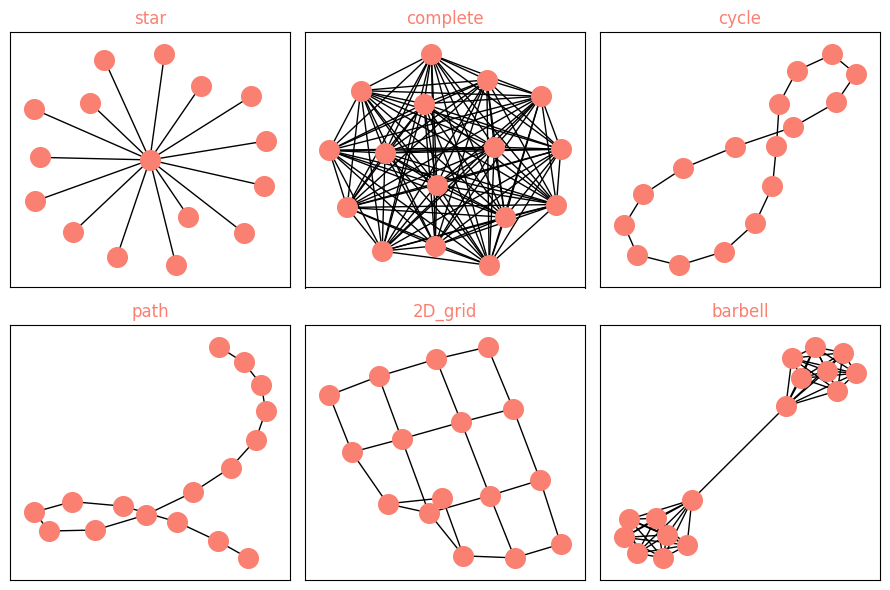

In [30]:
n_workers = 16
plot_all_fixed_graphs(n_workers)

### Graphs 2: Varying topology

We plot 2 sequences of 3 random geometric graphs (on which we forced the connectedness), with 2 different values of $\chi$ _( the $\chi$ displayed is the worst encountered in the sequence)_.\
In practice, we cycled through sequences of 50 graphs to simulate the time-varying setting, as done in [ADOM+](https://openreview.net/attachment?id=L8-54wkift&name=supplementary_material).

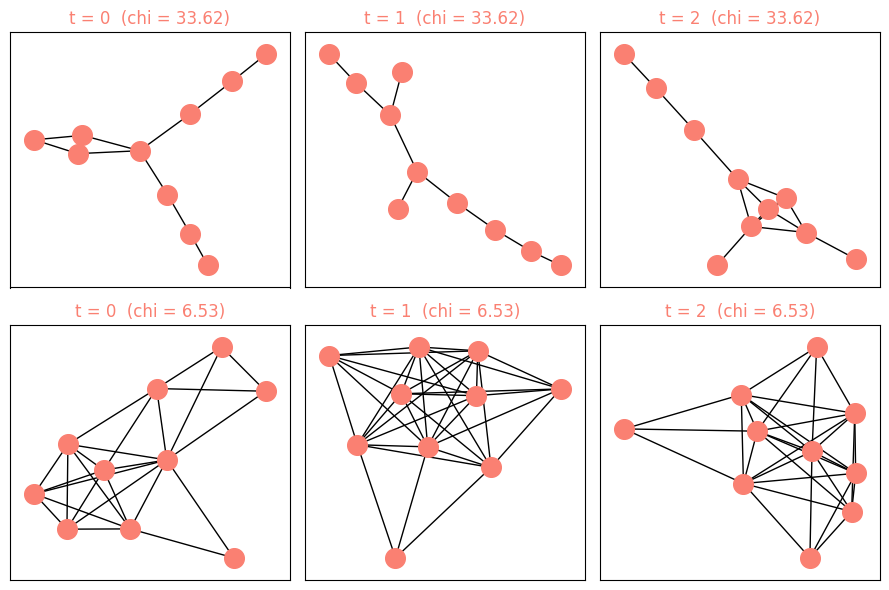

In [9]:
n_workers=10
plot_2_time_varying_graph_sequence(n_workers)

## Run the optimizers

#### Imports

In [350]:
import numpy as np
from main import main
from utils import compute_regularity_constants
import data
import importlib
importlib.reload(data)
from data import create_K_graphs, create_data
import visualization
import importlib
importlib.reload(visualization)
from visualization import print_communication_rates_fixed_topology, Args_for_main, plot_losses, plot_all_losses

import warnings
warnings.filterwarnings('ignore')

#### Data and Graphs specification

In [251]:
# Variables for the graphs
n_workers = 30
radius = 0.15
id_graph_type = 6

list_graph_name = ['star', 'complete', 'cycle', 'path', '2D_grid', 'barbell', 'random_geom']
graph_type = list_graph_name[id_graph_type]
# create 50 graphs of the type considered
list_G, list_W, list_L_norm, chi_1_star, chi_2_star, chi_star = create_K_graphs(n_workers, graph_type, radius)
# display the several communication rates
print_communication_rates_fixed_topology(list_G, list_L_norm, chi_1_star, chi_2_star, chi_star, graph_type)

 Communication rates for the different methods on the random_geom graph with 30 nodes. 
 We print the expected number of edges activated between two expected global rounds of gradient steps. 

 ADOM+ (ADOM+VR): 35 
 ADOM+ (ADOM+VR) with Multi-Consensus : 11795 
 Continuized : 383 
 MSDA : 525 
 DADAO : 383


In [398]:
import data
import importlib
import utils
importlib.reload(data)
importlib.reload(utils)

from utils import compute_regularity_constants
from data import create_data

# Variables for the datasets and task considered
n_samples = 100 * n_workers

classification = False
# dataset_name = "cpusmall.txt" #12
dataset_name = "cadata.txt"   #8
# dataset_name = "a9a.txt"      #123
dim = 8

data, labels = create_data(n_samples, dim, n_workers, classification, dataset_name)

# Regularity constants
mu, L = compute_regularity_constants(data, classification)
print(" Strong convexity coefficient : %.2f \n Smoothness coefficient : %.2f"%(mu,L))

# Initialize the arguments
args = Args_for_main(None, data, labels, classification, mu, L, dim, n_workers, chi_star, chi_1_star, chi_2_star, None, None, None, list_G, list_W, graph_type, steps=300)

 Strong convexity coefficient : 2.85 
 Smoothness coefficient : 42717012.06


#### [ADOM + VR]

In [1]:
import main
import importlib
importlib.reload(main)

args.optimizer_name = "ADOMplusVR"
args.use_multi_consensus = False
args.steps = 200

opt_adom_vr, grad_loss_adom_vr, com_loss_adom_vr = main.main(args)
plot_losses(grad_loss_adom_vr, com_loss_adom_vr, 'ADOM+VR', graph_type, n_workers)

In [1]:
args.optimizer_name = "ADOMplus"
args.use_multi_consensus = False
args.steps = 500
opt_adom, grad_loss_adom, com_loss_adom = main.main(args)

plot_losses(grad_loss_adom, com_loss_adom, 'ADOM+', graph_type, n_workers)

In [1]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(10, 4))
ax0 = f.add_subplot(121)
ax1 = f.add_subplot(122)
ax0.plot(np.arange(len(grad_loss_adom)), np.array(grad_loss_adom), label=r"ADOM+")
ax0.plot(np.arange(len(grad_loss_adom_vr)), np.array(grad_loss_adom_vr), label=r"ADOM+VR")
ax0.set(
    xlabel="Total number of gradient steps",
    ylabel=r"$\frac{1}{n} \sum_{i=1}^{n}\Vert x_i - x^*\Vert^2$",
    title="Gradient steps, %s graph, n = %d" % (graph_type, n_workers),
    yscale="log",
    # ylim=(1e4, 1e5)
)
ax0.legend(loc="upper right")
ax1.plot(np.arange(len(com_loss_adom)), np.array(com_loss_adom), label=r"ADOM+")
ax1.plot(np.arange(len(com_loss_adom_vr)), np.array(com_loss_adom_vr), label=r"ADOM+VR")
ax1.set(
    xlabel="Total number of communication steps",
    ylabel=r"$\frac{1}{n} \sum_{i=1}^{n}\Vert x_i - x^*\Vert^2$",
    title="Communication steps, %s graph, n = %d" % (graph_type, n_workers),
    yscale="log",
    # ylim=(1e1, 1e5)
)
ax1.legend(loc="upper right")
plt.tight_layout()
plt.show()

In [1]:
import importlib
import visualization
importlib.reload(visualization)
visualization.plot_all_losses(
    n_workers,
    grad_loss_adom, com_loss_adom,
    grad_loss_adom_vr, com_loss_adom_vr,
    graph_type,
    id_max=6e4,
    compression=99.9
)

### BEER+VR

In [1]:
import main
import importlib
importlib.reload(main)

args.optimizer_name = "BEERplusVR"
args.use_multi_consensus = False
args.steps = 100

opt_beer_vr, grad_loss_beer_vr, com_loss_beer_vr = main.main(args)
plot_losses(grad_loss_beer_vr, com_loss_beer_vr, 'BEER+VR', graph_type, n_workers)